<a href="https://colab.research.google.com/github/Doris-QZ/Transformers_from_Scratch--BERT_and_GPT2_in_PyTorch/blob/main/3_Rebuilding_GPT_2_Model_from_Scratch_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook, I implement GPT-2 Small from the ground up using PyTorch. Although dozens of LLMs are released every month, GPT-2 remains a great starting point for understanding transformer-based language models, since the core architecture has not changed significantly in recent LLMs.   
</br>

The workflow is as follows:

* **Dataset preparation**: The IMDb dataset (from Hugging Face) is preprocessed for language modeling, including a custom batching function to extract input–target pairs for training.

* **Model implementation**: outline the GPT-2 architecture, then implement the GPT-2 Small configuration (12 layers, 12 heads, 768 hidden size, 1024 context length).

* **Training and text generation**: The model is trained for 1000 steps to verify correctness and convergence, and the trained model is used to generate a short piece of text to demonstrate functionality.
</br>

This exercise is not about achieving state-of-the-art performance, but about **deepening understanding of GPT-2’s design and training process** by re-building it from scratch.

In [ ]:
# Data preparation
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer

# Modeling
import torch
from torch import nn
from transformers import get_cosine_schedule_with_warmup
import math
import copy

In [ ]:
# Use GPU when it's available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

### Data Preparation

In [ ]:
# Suppress the warning
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Load the data
imdb_data = load_dataset('imdb', split='train')

In [ ]:
# Take a look at the data
print(f"{imdb_data}\n")
imdb_data[0]

GPT-2 uses **Byte Pair Encoding (BPE)**, a subword tokenization algorithm, with a vocabulary size of 50,257 in the small GPT-2 model. Here, we use the GPT-2 tokenizer from the Hugging Face transformers package to simplify the data preparation process.

In [ ]:
# Load GPT2 tokenizer
gpt2_tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")

# Add paddding token if missing
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

In [ ]:
# Split the data
split_idx = int(len(imdb_data) * 0.9)

# Store tensors
train_tensors = []
val_tensors = []

# Iterate through the dataset and tokenize each 'text'
for i in range(split_idx):
    text = imdb_data[i]["text"]
    tokens = gpt2_tokenizer.encode(text, max_length=1024, truncation=True, return_tensors='pt')
    train_tensors.append(tokens)

for i in range(split_idx, len(imdb_data)):
    text = imdb_data[i]["text"]
    tokens = gpt2_tokenizer.encode(text, max_length=1024, truncation=True, return_tensors='pt')
    val_tensors.append(tokens)

# Concatenate list of tensors into one big tensor
train_tensors = torch.cat(train_tensors, dim=1)
val_tensors = torch.cat(val_tensors, dim=1)

print(train_tensors.shape)
print(val_tensors.shape)

In [ ]:
# Convert the 2d tensors to 1d tensors
train_tensors = train_tensors.squeeze(0)
val_tensors = val_tensors.squeeze(0)

The original GPT-2 paper trained with a batch size of **512** and a context size of 1024 tokens. Here, we keep the same context size but **reduce the batch size to 4 to avoid exceeding GPU memory**.

In [ ]:
def create_batch_tensor(split='train', batch_size=4, seq_length=1024):
    """
    Randomly extracts a batch of input and target tensors for language model training.

    Args:
        split (str): The dataset split to use ('train' or 'val').
        batch_size (int): The number of sequences to include in the batch.
        seq_length (int): The length of each sequence.

    Returns:
        A tuple containing two tensors:
        - inputs (torch.Tensor): A tensor of shape [batch_size, seq_length] containing the input sequences.
        - targets (torch.Tensor): A tensor of shape [batch_size, seq_length] containing the target sequences.
    """

    # Select the appropriate dataset based on the 'split' argument
    data = train_tensors if split=='train' else val_tensors

    # Calculate the maximum possible starting index for sequence extraction
    n = len(data) - seq_length - 1

    # Get a batch of random starting indices
    start_idx = torch.randint(0, n, (batch_size,))

    # Get indices of shape [batch_size, seq_length]  for each token in the batch
    input_indices = start_idx.unsqueeze(1) + torch.arange(seq_length)
    target_indices = input_indices + 1

    # Extract inputs and targets from the data tensor
    inputs = data[input_indices]
    targets = data[target_indices]

    return inputs, targets


### Model Implementation

**Model Architecture**

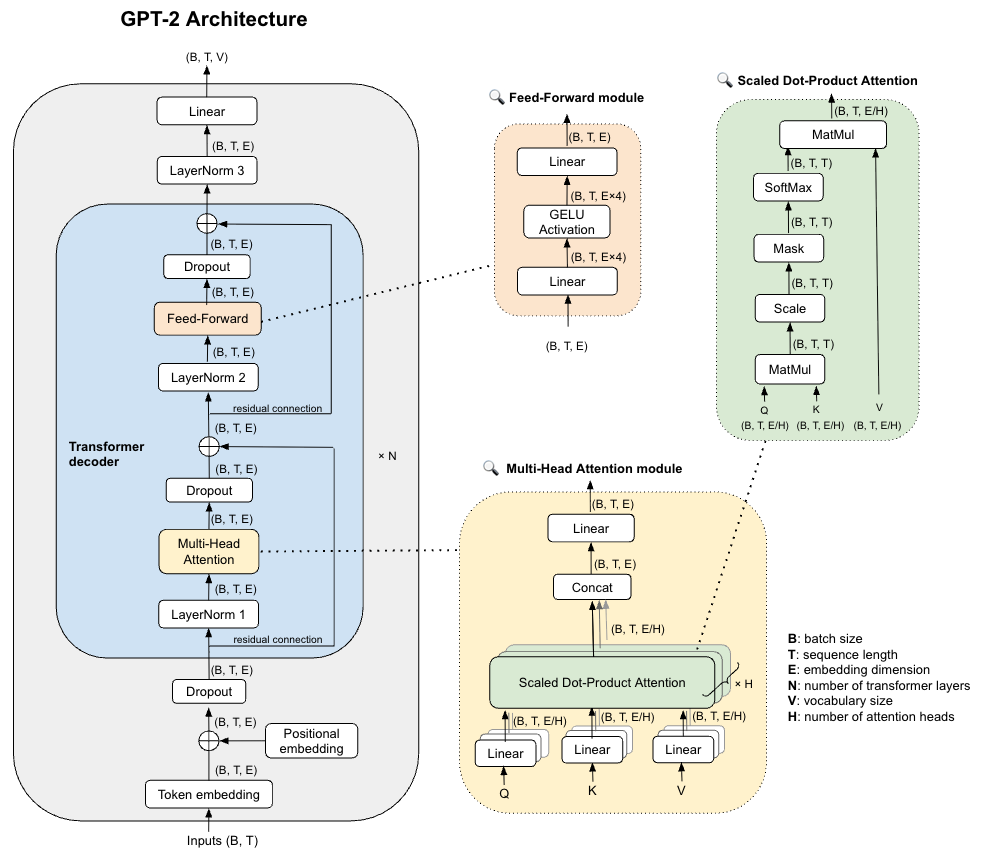



The GPT-2 Model is composed of three main components:

1. **Embedding Layer**:  
* Token embedding + Positional embedding

2. **Transformer Block**:  
* Each block contains:
    * Multi-head attention
    * Feed-forward module
    * Residual connections and layer normalization applied after each sub-layer
* Repeated **N** times depending on model size:
    | Parameters | Layers (N) | d_model |
    | :--: | :--: | :--: |
    | 117M | 12 | 768 |
    | 345M | 24 | 1024 |
    | 762M | 36 | 1280 |
    | 1542M | 45 | 1600 |
  
3. **Output Layer**:  
* Linear projection for language modeling predictions

</br>

**Model Parameters**:

In this project, we will rebuild the small GPT-2 model, using the parameter settings described in the GPT and GPT-2 paper:

* Vocabulary size: 50257
* Number of transformer layers: 12
* Number of attention heads: 12
* Embedding dimension: 768
* Feed-forward dimension: 3072
* Sequence length(context size): 1024
* Dropout: 0.1
* Activation function: GELU
* Optimizer: Adam
* Max learning rate: 2.5e-4

In [ ]:
# Multi-Head Attention module for GPT-2 (decoder-style Transformer block)
class Multi_Head_Attention(nn.Module):
    def __init__(self, num_heads=12, d_model=768, seq_length=1024, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.d_model = d_model

        # Linear projection to obtain Q, K, V in one go (split later into 3 parts)
        self.c_attn = nn.Linear(in_features=d_model, out_features=d_model * 3)

        # Linear projection after concatenating all heads
        self.c_proj = nn.Linear(in_features=d_model, out_features=d_model)

        # Dropout applied on attention weights
        self.attn_dropout = nn.Dropout(p=dropout)

        # Lower-triangular causal mask to prevent attending to future positions
        mask = torch.tril(torch.ones(seq_length, seq_length))
        self.register_buffer('mask', mask)

    def scaled_dot_product_attention(self, Q, K, V):
        # Q, K, V: [batch_size, num_heads, seq_length, head_dim]
        _, _, T, d_k = Q.shape

        # Attention score = QK^T / sqrt(d_k)
        attn_score = Q @ K.transpose(-2, -1) / math.sqrt(d_k)   # [B, H, T, T]

        # Apply causal mask
        mask = self.mask[:T, :T]
        attn_score.masked_fill_(mask==0, float('-inf'))

        # Softmax over the last dimension -> attention weights
        attn_weight = attn_score.softmax(dim=-1)

        # Dropout on attention weights
        attn_weight = self.attn_dropout(attn_weight)

        # Weighted sum of values
        attn_output = attn_weight @ V   # [B, H, T, d_k]

        return attn_output

    def forward(self, x):
        # Input: [batch_size, seq_length, d_model]
        B, T, E = x.shape

        # Project input to Q, K, V: [B, T, d_model * 3] -> split into 3 tensors
        Q, K, V = self.c_attn(x).chunk(3, dim=-1)

        # Reshape and transpose: [B, T, d_model] -> [B, H, T, d_k]
        d_k = E // self.num_heads
        Q = Q.view(B, T, self.num_heads, d_k).transpose(1, 2)
        K = K.view(B, T, self.num_heads, d_k).transpose(1, 2)
        V = V.view(B, T, self.num_heads, d_k).transpose(1, 2)

        # Apply scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V)

        # Concatenate heads: [B, nh, T, d_k] -> [B, T, d_model]
        concat_output = attn_output.transpose(1, 2).contiguous().view(B, T, E)

        # Final linear projection
        output = self.c_proj(concat_output) # [B, T, d_model]

        return output


In [ ]:
# Feed-Forward module for GPT-2 (decoder-style Transformer block)
class Feed_Forward(nn.Module):
    def __init__(self, d_model=768, d_ff=3072):
        super().__init__()

        self.linear1 = nn.Linear(in_features=d_model, out_features=d_ff)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(in_features=d_ff, out_features=d_model)

    def forward(self, x):
        x = self.gelu(self.linear1(x))
        x = self.linear2(x)

        return x

In [ ]:
# Transformer decoder block for GPT-2
class Transformer_Decoder(nn.Module):
    def __init__(self, num_heads=12, d_model=768, seq_length=1024, d_ff=3072, dropout=0.1):
        super().__init__()

        # The first LayerNorm applied before Multi-Head-Attention
        self.ln_1 = nn.LayerNorm(d_model)

        # Multi-Head-Attention module
        self.attn = Multi_Head_Attention(num_heads=num_heads,
                                                    d_model=d_model,
                                                    seq_length=seq_length,
                                                    dropout=dropout)

        # Dropout and LayerNorm applied after Multi-Head-Attention
        self.resid_dropout = nn.Dropout(p=dropout)
        self.ln_2 = nn.LayerNorm(d_model)

        # Feed-Forward module (multi-layer perceptron)
        self.mlp = Feed_Forward(d_model=d_model, d_ff=d_ff)

        # Dropout applied on Feed-Forward output
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Input: [batch_size, seq_length, d_model]
        # LayerNorm 1
        ln1_output = self.ln_1(x)

        # Multi-Head Attention and Dropout
        attn_output = self.resid_dropout(self.attn(ln1_output))

        # Residual Connection
        attn_output = attn_output + x

        # LayerNorm 2
        ln2_output = self.ln_2(attn_output)

        # Feed-Forward and Dropout
        mlp_output = self.dropout(self.mlp(ln2_output))

        # Residual Connection
        output = attn_output + mlp_output

        return output

In [ ]:
# GPT2 Small model
class GPT2_S(nn.Module):
    def __init__(self, vocab_size=50257, num_heads=12, d_model=768, seq_length=1024,
                 num_layers=12, d_ff=3072, dropout=0.1):
        super().__init__()

        self.seq_length = seq_length
        self.N = num_layers

        # Token embedding
        self.wte = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)

        # Positional embedding
        self.wpe = nn.Embedding(num_embeddings=seq_length, embedding_dim=d_model)

        # Dropout applied on embeddings
        self.drop = nn.Dropout(p=dropout)

        # Transformer decoder block
        transformer_decoder = Transformer_Decoder(num_heads=num_heads, d_model=d_model,
                                                  seq_length=seq_length, d_ff=d_ff, dropout=dropout)
        self.transformer_block = nn.ModuleList([copy.deepcopy(transformer_decoder) for _ in range(num_layers)])

        # LayerNorm applied on transformer block output
        self.ln_f = nn.LayerNorm(d_model)

        # Linear projection for language modeling
        self.lm_head = nn.Linear(in_features=d_model, out_features=vocab_size)

        # Weight initiation
        self.init_weights()


    def init_weights(self):
        for name, param in self.named_parameters():
            if param.dim() > 1:
                if 'c_proj' in name:
                    # Initialize residual projection weights with N(0, 0.02/√N), per GPT-2 paper
                    nn.init.normal_(param, mean=0.0, std=0.02 / math.sqrt(self.N))
                else:
                    # Initialize other weight matrices with N(0, 0.02)
                    nn.init.normal_(param, mean=0.0, std=0.02)
            elif 'ln_' in name and 'weight' in name:
                # Initialize LayerNorm γ to 1.0
                param.data.fill_(1.0)
            else:
                # Initialize biases to 0
                param.data.zero_()

    def forward(self, x):
        # input: [batch_size, seq_length]
        # Get position indices and move to the same device as x
        pos = torch.arange(0, x.shape[1], dtype=torch.long, device=x.device)

        # Dropout applied on (Token embedding + positional embedding)
        x = self.drop(self.wte(x) + self.wpe(pos))  #[B, T, E]

        # Transformer block output
        for decoder in self.transformer_block:
            x = decoder(x)  #[B, T, E]

        # LayerNorm
        x = self.ln_f(x)    #[B, T, E]

        return self.lm_head(x)     #[B, T, V]

    @torch.no_grad()
    def generate(self, prompt, tokenizer=gpt2_tokenizer, max_new_tokens=500, temperature=1.0, top_k=50, top_p=1.0):
        # Tokenize and truncate the prompt from the left to fit the maximum sequence length
        tokenizer.truncation_side = "left"
        idx = tokenizer.encode(prompt, max_length=self.seq_length, truncation=True, return_tensors='pt').to(self.wte.weight.device)
        _, T = idx.shape    #[1, seq_length]

        # Generate up to 'max_new_tokens' new tokens
        for _ in range(max_new_tokens):
            # Use only the most recent 'seq_length' tokens as context
            context = idx[:, -self.seq_length:]

            # Forward pass -> logits
            logits = self.forward(context)[:, -1, :]   #[1, vocab_size]

            # Apply temperature scaling
            logits = logits / temperature

            # Apply top_k sampling
            if top_k is not None:
                # Get the top_k largest logits and their indices
                values, indices = torch.topk(logits, k=top_k, dim=-1)

                # Initialize a tensor with the same size as 'logits' and filled iwith '-inf'
                logits = torch.full_like(logits, float('-inf'))

                # Fills back the top-k logits into their original positions
                logits.scatter_(dim=-1, index=indices, src=values)

            # Apply top_p sampling
            if top_p is not None:
                # Sort logits and compute cumulative probabilities
                sorted_logits, sorted_indices = torch.sort(logits, dim=-1, descending=True)
                cum_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)

                # Mask tokens with cumulative probability above top_p
                cutoff = cum_probs > top_p
                cutoff[..., 1:] = cutoff[..., :-1].clone()  # shift mask right
                cutoff[..., 0] = False  # Ensure the first token is never cut off
                sorted_logits[cutoff] = float('-inf')   # Set the sorted_logits at 'True' positions to be '-inf'

                 # Initialize a tensor with the same size as 'logits' and filled iwith '-inf'
                logits = torch.full_like(logits, float('-inf'))

                # Fills back the top-p logits into their original positions
                logits.scatter_(dim=-1, index=sorted_indices, src=sorted_logits)

            # Convert logits to probabilities
            lm_prob = torch.softmax(logits, dim=-1)

            # Sample the next token
            next_idx = torch.multinomial(lm_prob, num_samples=1)

            # Apend the token to the sequence
            idx = torch.cat((idx, next_idx), dim=1)

            # Stop if EOS token is generated
            if next_idx.item() == tokenizer.eos_token_id:
                break

        # Decode only the generated tokens (exclude the prompt)
        return tokenizer.decode(idx[0, T:])

### Training and Generation

We train the model for 1,000 steps to verify correctness and convergence, and then use it to generate a short text sample to demonstrate its functionality.

In [ ]:
# Instantiate a GPT2 small model
model = GPT2_S().to(device)

# Define the optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=2.5e-4)

# Define learning rate scheduler
training_steps = 1000
warmup_steps = int(training_steps * 0.01)
lr_scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer,
                                               num_warmup_steps= warmup_steps,
                                               num_training_steps=training_steps)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def training_loop(model, data_collate_fn, training_steps, test_steps, optimizer, lr_scheduler, loss_fn):
    history = {'train_loss':[], 'test_loss':[]}
    train_loss = 0

    for i in range(1, training_steps+1):
        # Set model to training mode
        model.train()

        # Get a training batch
        inputs, targets = data_collate_fn(split='train')
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(inputs)
        B, T, V = logits.shape

        # Compute loss
        loss = loss_fn(logits.view(-1, V), targets.view(-1))

        # Backpropagation
        loss.backward()

        # Clip gradients to prevent explosion
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters and lr_scheduler
        optimizer.step()
        lr_scheduler.step()

        train_loss += loss.item()

        # Log every 100 steps
        if i % 100 == 0:
            current_train_loss = train_loss/100
            history['train_loss'].append(current_train_loss)
            train_loss = 0

            # Set model to evaluating mode
            model.eval()
            test_loss = 0

            with torch.inference_mode():
                for _ in range(test_steps):
                    inputs, targets = data_collate_fn(split='val')
                    inputs, targets = inputs.to(device), targets.to(device)

                    logits = model(inputs)
                    B, T, V = logits.shape
                    loss = loss_fn(logits.view(-1, V), targets.view(-1))
                    test_loss += loss.item()

                current_test_loss = test_loss/test_steps
                history['test_loss'].append(current_test_loss)
            print(f"Train_Loss: {current_train_loss:.3f} | Test_Loss: {current_test_loss: .3f}")

    return history

In [ ]:
history = training_loop(model=model,
                        data_collate_fn=create_batch_tensor,
                        training_steps=training_steps,
                        test_steps=int(training_steps/50),
                        optimizer=optimizer,
                        lr_scheduler=lr_scheduler,
                        loss_fn=loss_fn)

In [ ]:
model.generate("How's your day?", tokenizer=gpt2_tokenizer, max_new_tokens=50, temperature=1.0, top_k=50, top_p=0.9)

**The model didn’t generate a good response, which is understandable since it was only trained for 1000 steps on a very limited dataset. I believe it would perform much better with more training steps and a larger, more diverse dataset.**

### Reference

* Vaswani, Ashish, et al. "[Attention is all you need.](https://arxiv.org/abs/1706.03762)" Advances in neural information processing systems 30 (2017).
* Radford, Alec, et al. "[Improving language understanding by generative pre-training.](https://www.mikecaptain.com/resources/pdf/GPT-1.pdf)" (2018): 3.
* Radford, Alec, et al. "[Language models are unsupervised multitask learners.](https://storage.prod.researchhub.com/uploads/papers/2020/06/01/language-models.pdf)" OpenAI blog 1.8 (2019): 9.